# **Readmission prediction**

Our goal is to predict the readmission of diabetes patients within 30 days of discharge. The analysis is based on the [Diabetes 130-US hospitals for years 1999-2008 UCI data set](https://archive.ics.uci.edu/ml/datasets/diabetes+130-us+hospitals+for+years+1999-2008). For our project the above data set was subsampled into **10k** samples and expanded with the descriptions of the ICD codes.  

This notebook visualizes variables in the dataset in the hope of getting useful insights for the subsequent analysis. It consists of the following parts

1. General data exploration / summaries 
2. Feature inspection
    1. Numeric variables
    2. Categorical variables
    3. Textual input
        1. Word2Vec
        2. LDA topic modelling
5. Visual analysis of missing data

In [ ]:
import pandas as pd
import numpy as np
import string

from scipy import stats

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import accuracy_score, f1_score, roc_curve, roc_auc_score
from sklearn.manifold import TSNE


from gensim import corpora, models
from gensim.models import Word2Vec
from wordcloud import WordCloud

import pyLDAvis
import pyLDAvis.gensim

import nltk
from nltk import FreqDist, word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
nltk.download('stopwords')
nltk.download('punkt')

# Packages for plotting
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style()
import umap
matplotlib.rcParams.update({'font.size': 14})

# **General data exploration / summaries**

In [2]:
X_train = pd.read_csv("../input/diab_train.csv", index_col=0)
X_Y_train = X_train.copy()
Y_train = X_train["readmitted"]
X_train = X_train.drop(columns="readmitted")

X_val = pd.read_csv("../input/diab_validation.csv", index_col=0)
Y_val = X_val["readmitted"]
X_val = X_val.drop(columns="readmitted")

X_test  = pd.read_csv("../input/diab_test.csv", index_col=0)
Y_test = X_test["readmitted"]
X_test = X_test.drop(columns="readmitted")

# Just for convenience, if we want to check that certain values are in all datasets and that the distribution does not differ
X_all = pd.concat([X_train, X_val, X_test])
Y_all = pd.concat([Y_train, Y_val, Y_test])
X_all["partition"] = np.concatenate([np.repeat("train", len(X_train)), np.repeat("val", len(X_val)), np.repeat("test", len(X_test))])
X_Y_all = pd.merge(X_all, Y_all, left_index=True, right_index=True)

We compare the distribution of positive and negative cases between *train* *test* and *valication* datasets. 

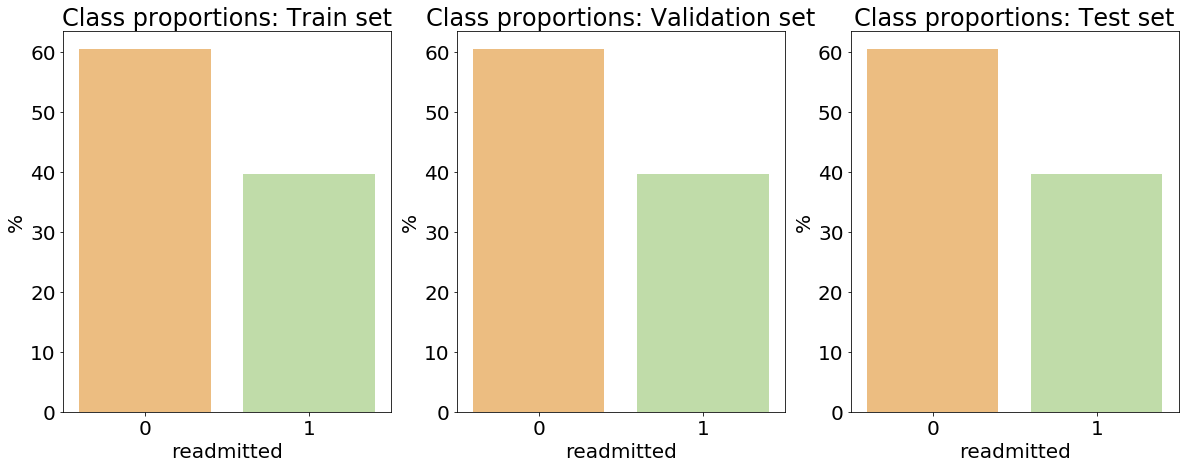

In [3]:
matplotlib.rcParams.update({'font.size': 20})
rows, cols = 1, 3

fig, axs = plt.subplots(rows, cols, figsize=(20, 7))


target_counts = pd.DataFrame(Y_train.value_counts()*100/X_train.shape[0]).reset_index()
target_counts = target_counts.rename(columns={"readmitted":"%", "index":"readmitted"})
sns.barplot(x="readmitted", y="%", data=target_counts, ax=axs[0], palette="Spectral")
axs[0].set_title("Class proportions: Train set")


target_counts = pd.DataFrame(Y_val.value_counts()*100/X_val.shape[0]).reset_index()
target_counts = target_counts.rename(columns={"readmitted":"%", "index":"readmitted"})
sns.barplot(x="readmitted", y="%", data=target_counts, ax=axs[1], palette="Spectral")
axs[1].set_title("Class proportions: Validation set")

target_counts = pd.DataFrame(Y_test.value_counts()*100/X_test.shape[0]).reset_index()
target_counts = target_counts.rename(columns={"readmitted":"%", "index":"readmitted"})
sns.barplot(x="readmitted", y="%", data=target_counts, ax=axs[2], palette="Spectral")
axs[2].set_title("Class proportions: Test set")

plt.show()

**Observations**

1. percentage of re-admitted patients in *train*, *test* and *validation* datasets is approximately the same
2. all datasets are unbalanced whereby readmitted patients constitute just 40% of observations

## Feature inspection (General Overview)

The dataset contains **50** different features of various types and with missing values. The following code explores sample values for each feature. If the number of unique values in the datasets is lower than `num_values_to_print` we print all the unique values, otherwise we print 5 sample values

In [4]:
num_values_to_print = 18

print("----------------------------------------------------")
for feature in X_train.columns:
    #print("****** " + str(feature) + " ****** " + str(len(X_train[feature].value_counts())))
    num_unique_val = len(X_train[feature].value_counts())
    print("Varialbe: {}\nNumber of unique values: {}".format(feature,  str(num_unique_val) ))
    sample_values = X_train[0:5][feature].values
    comment = "Sample values: "
    if(num_unique_val) < num_values_to_print:
        try:
            sample_values = list(X_train[feature].value_counts().index)#np.unique(X_train[feature])
            comment = "Unique values"
        except:
            pass 
    print( "{}: {}".format(comment, sample_values ))
    print("----------------------------------------------------")

----------------------------------------------------
Varialbe: race
Number of unique values: 6
Unique values: ['Caucasian', 'AfricanAmerican', '?', 'Hispanic', 'Other', 'Asian']
----------------------------------------------------
Varialbe: gender
Number of unique values: 2
Unique values: ['Female', 'Male']
----------------------------------------------------
Varialbe: age
Number of unique values: 10
Unique values: ['[70-80)', '[60-70)', '[50-60)', '[80-90)', '[40-50)', '[30-40)', '[90-100)', '[20-30)', '[10-20)', '[0-10)']
----------------------------------------------------
Varialbe: weight
Number of unique values: 8
Unique values: ['?', '[75-100)', '[50-75)', '[100-125)', '[125-150)', '[25-50)', '[150-175)', '[0-25)']
----------------------------------------------------
Varialbe: admission_type_id
Number of unique values: 6
Unique values: ['Emergency', 'Urgent', 'Elective', 'Not Available', 'Not Mapped', 'Newborn']
----------------------------------------------------
Varialbe: disch

Based on this overview  and the [features' descriptions](https://www.hindawi.com/journals/bmri/2014/781670/tab1) we can divide our variables into several groups and examine them separately in dedicated sections.


In [5]:
categorical = ["race", "gender", "age", "payer_code",
               "max_glu_serum", "weight",
               "A1Cresult", "change", "diabetesMed",
               "admission_type_id", "admission_source_id", 
               "discharge_disposition_id", "medical_specialty"]


categorical_medicine_pre = ["metformin", "repaglinide", "nateglinide", "chlorpropamide", 
                            "glimepiride", "acetohexamide", "glipizide", "glyburide", "tolbutamide", 
                            "pioglitazone", "rosiglitazone", "acarbose", "miglitol", "troglitazone",
                            "tolazamide", "examide", "citoglipton", "insulin","glyburide.metformin", 
                            "glipizide.metformin", "glimepiride.pioglitazone", 
                            "metformin.rosiglitazone", "metformin.pioglitazone"]

numerical = ["time_in_hospital", "num_procedures", "number_outpatient", "number_emergency", 
             "number_inpatient", "number_diagnoses","num_medications", "num_lab_procedures"]

diagnosis_codes = ["diag_1", "diag_2", "diag_3"]
diagnosis_descriptions = ["diag_1_desc", "diag_2_desc", "diag_3_desc"]

all_features = categorical + categorical_medicine_pre + \
               numerical +\
               diagnosis_codes + diagnosis_descriptions


assert len(all_features) == len(X_train.columns), "{} != {}".format(len(all_features), len(X_train.columns))

# **Feature analysis**

## **Categorical**

The dataset contains **13** categorical variables, below we provide the description of some of them:

* `max_glu_serum`: represents glucose serum test result, indicates the range of the result or if the test was not taken.
* `A1Cresult`: represents A1C test result, indicates the range of the result or if the test was not taken. “normal” if the result was less than 7%
* `change`: indicates if there was a change in diabetic medications, "Ch" - change
* `diabetesMed`: indicates if there was any diabetic medication prescribed
* `medical_specialty`:  specialty of the admitting physician
* `admission_type_id`: text categories, if missing "Not Available", also "Not Mapped"  
* `admission_source_id`: text categories, if missing "Not Available", also "Not Mapped"  
* `discharge_disposition_id`: text categories, if missing "Not Mapped"  


In [6]:
categorical = ["race", "gender", "age", "payer_code",
               "max_glu_serum", "weight",
               "A1Cresult", "change", "diabetesMed",
               "admission_type_id", "admission_source_id", 
               "discharge_disposition_id", "medical_specialty"]

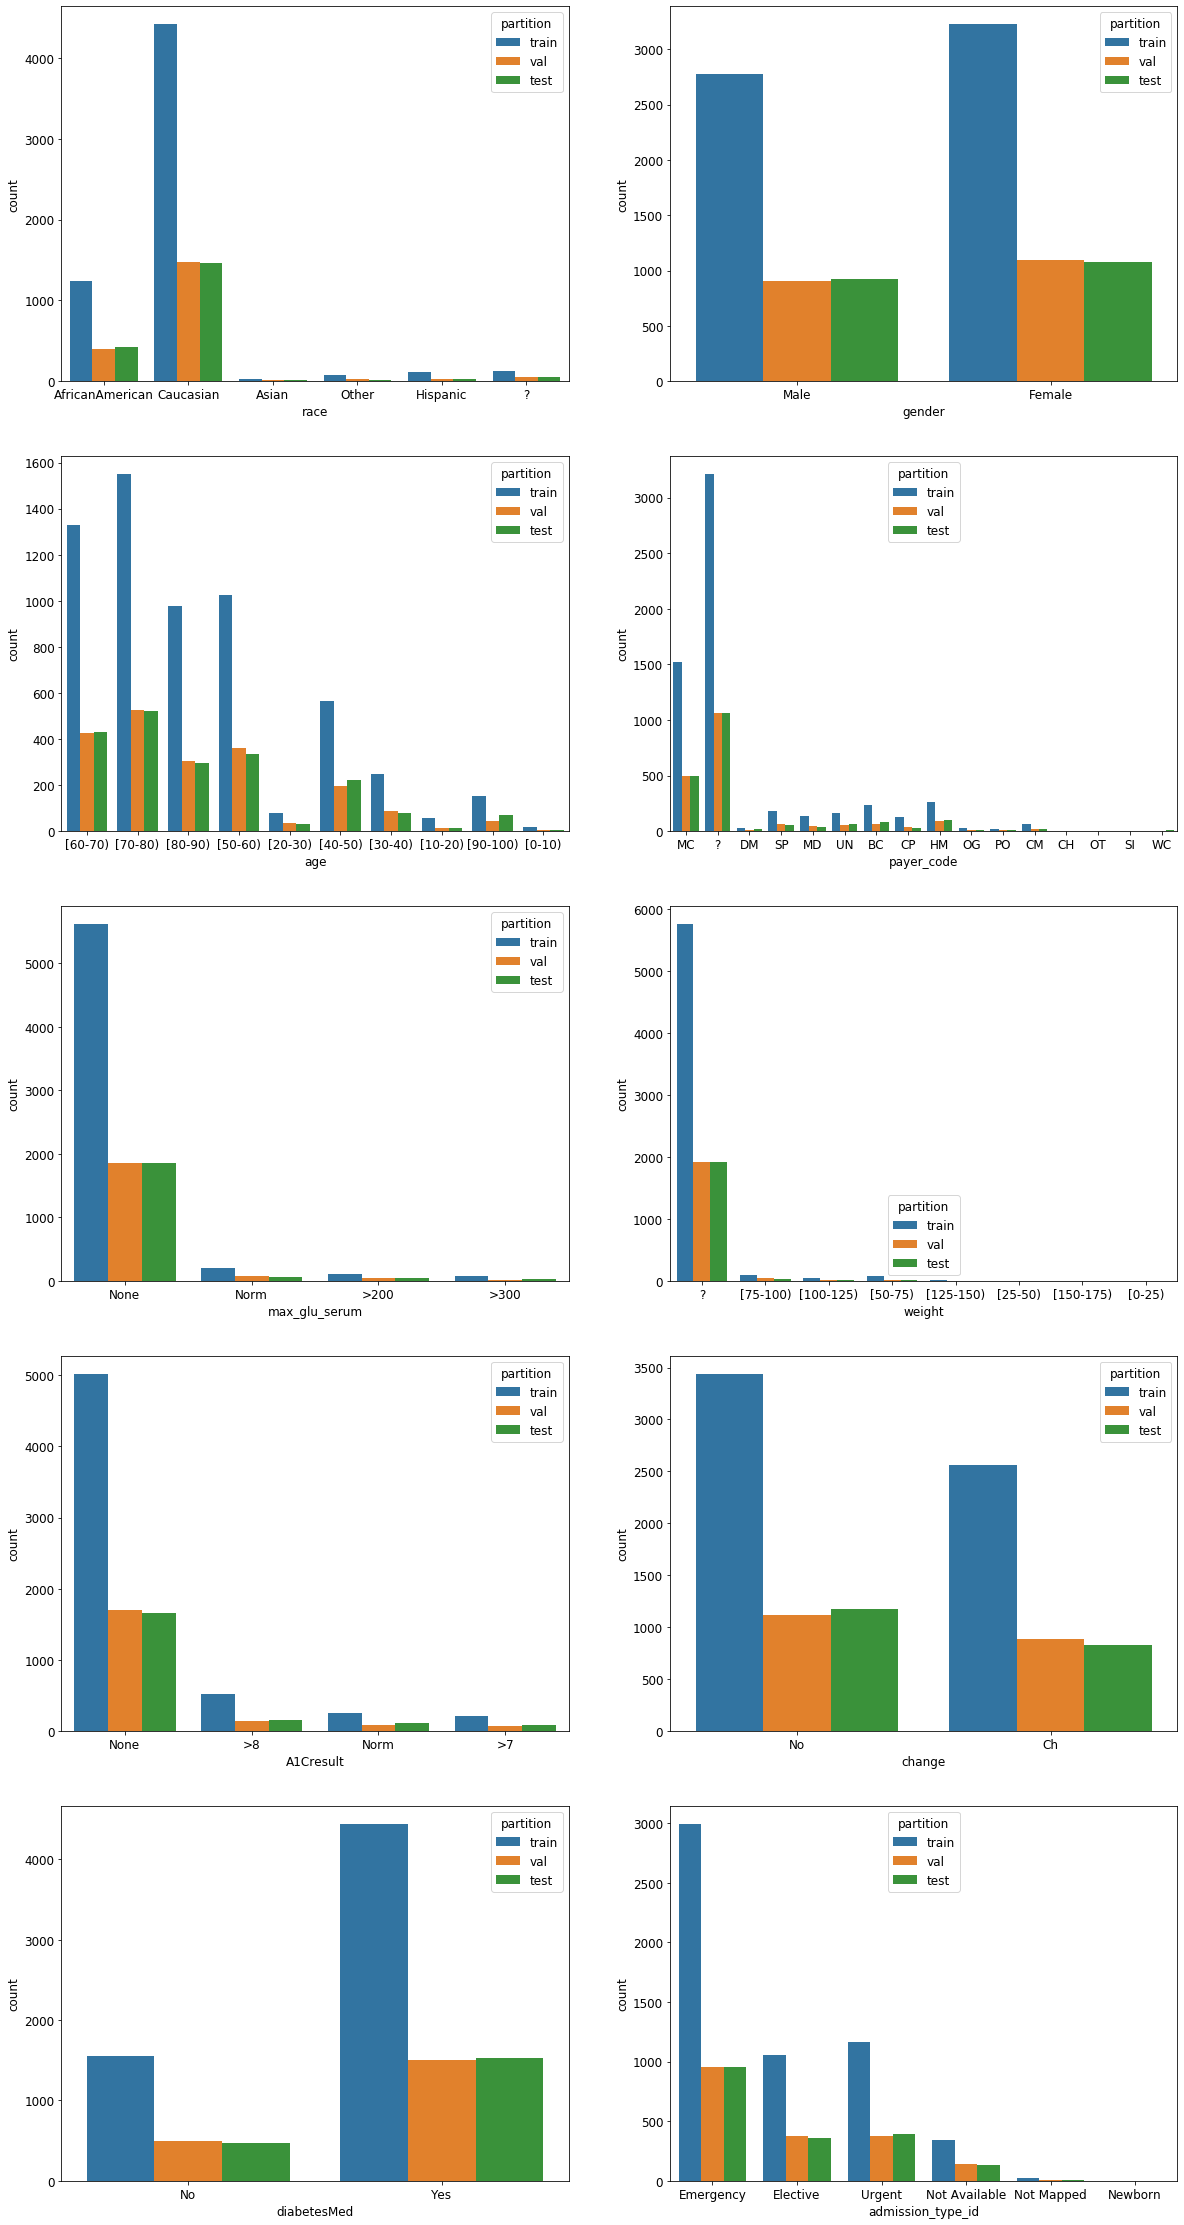

In [7]:
matplotlib.rcParams.update({'font.size': 12})
rows, cols = 5, 2

fig, axs = plt.subplots(rows, cols, figsize=(20,40))
for i, feat in enumerate(categorical[:-3]):
    row = i//cols
    col = i%cols
    chart = sns.countplot(x=feat, data=X_Y_all, ax=axs[row,col], hue="partition") #palette="Spectral")
    chart.set_xticklabels(chart.get_xticklabels(), rotation=0)
plt.show()

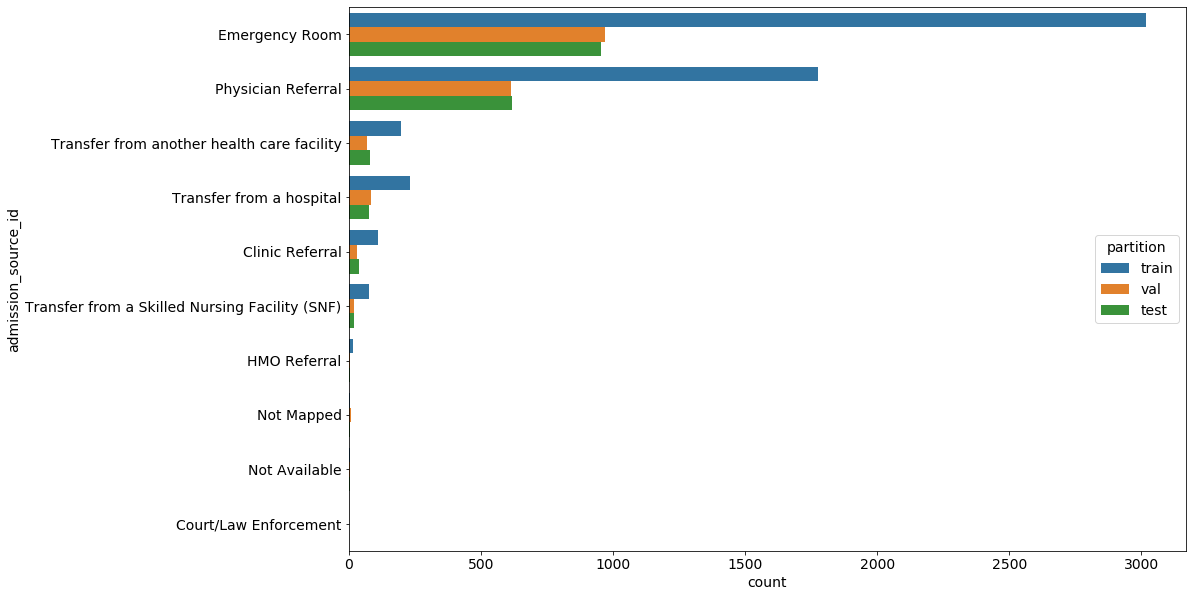

In [8]:
matplotlib.rcParams.update({'font.size': 14})


fig = plt.figure(figsize=(15,10))
sns.countplot(y="admission_source_id", data=X_Y_all, hue="partition") #data=X_train, palette="Spectral")

plt.show()

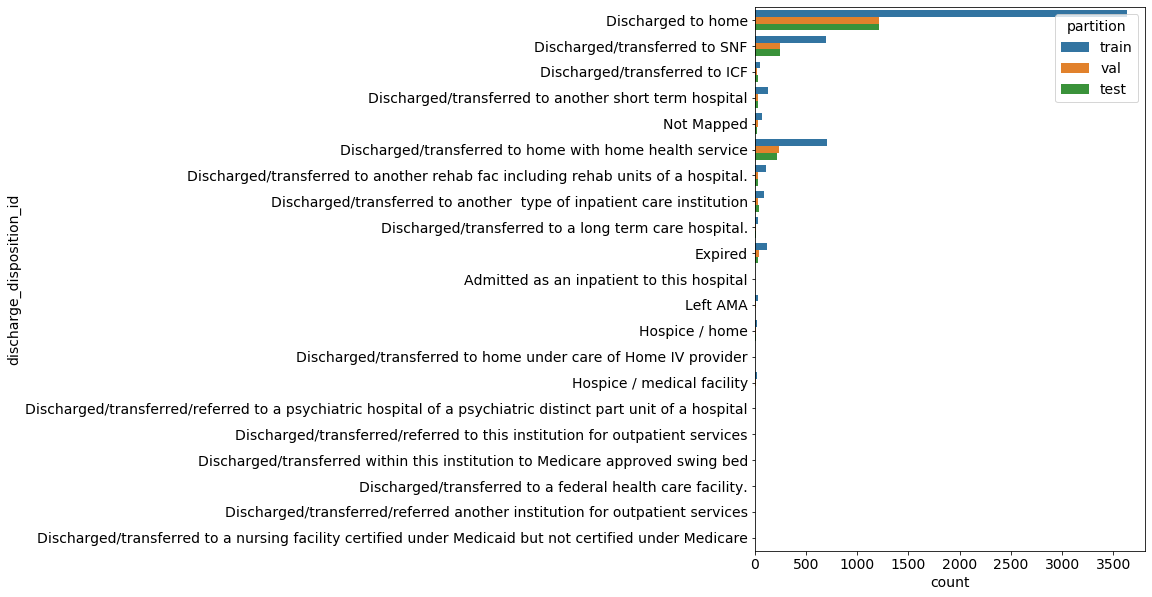

In [9]:
matplotlib.rcParams.update({'font.size': 14})

fig = plt.figure(figsize=(7,10))
sns.countplot(y="discharge_disposition_id", data=X_Y_all, hue="partition") # palette="Spectral"

plt.show()

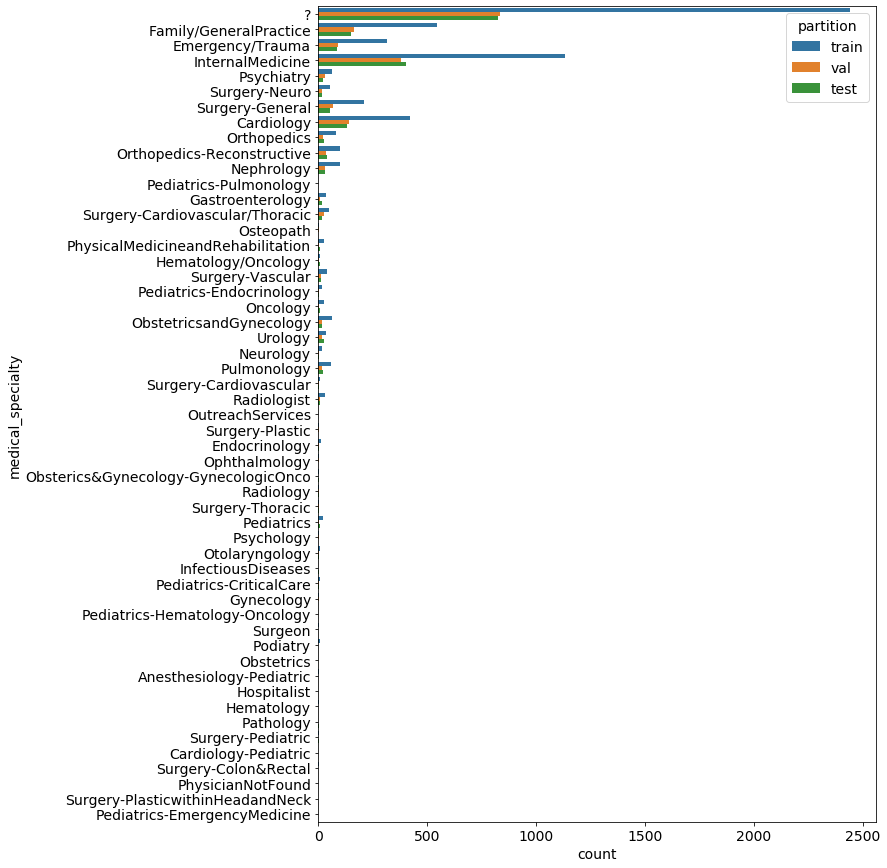

In [10]:
matplotlib.rcParams.update({'font.size': 14})

fig = plt.figure(figsize=(10,15))
sns.countplot(y="medical_specialty", data=X_Y_all, hue="partition") #data=X_train, palette="Spectral")

plt.show()

In [11]:
pd.crosstab(X_train['admission_source_id'], X_train['admission_type_id'])

admission_type_id,Elective,Emergency,Newborn,Not Available,Not Mapped,Urgent
admission_source_id,,,,,,
Clinic Referral,39,22,0,0,3,44
Emergency Room,36,2541,0,1,7,316
HMO Referral,13,3,0,0,0,1
Not Available,0,0,0,0,0,7
Not Mapped,2,1,0,0,0,4
Physician Referral,877,114,0,115,17,612
Transfer from a Skilled Nursing Facility (SNF),10,55,0,0,0,12
Transfer from a hospital,67,23,1,1,0,137
Transfer from another health care facility,7,184,0,0,0,9


In [12]:
merge_admis_type = pd.merge(right=X_train['admission_type_id'], left=Y_train, right_index=True, left_index=True)
pd.crosstab(merge_admis_type["admission_type_id"], 
            merge_admis_type["readmitted"],
            normalize=False)

readmitted,0,1
admission_type_id,,
Elective,654,399
Emergency,1811,1185
Newborn,1,0
Not Available,226,115
Not Mapped,18,9
Urgent,712,454


In [13]:
val1 = 1185.0/(1185 + 1811)
val2 = 454.0/(454 + 712)
val0 = 399.0/(654+399)
print("Emergency: {:.4f} Urgent: {:.4f}  Elective: {:.4f}".format(val1, val2, val0))

Emergency: 0.3955 Urgent: 0.3894  Elective: 0.3789


<h2>Observations about numerical variables:</h2>

* the distribution of categorical variables apperas to be the same in *train*, *validation* and *test* datasets
* `admission_type_id`: case severity is seems to be ordered as follows: 'Emergency' > 'Urgent' > 'Elective'. Have one "outlier" case when category is 'Newborn'
* `admission_source_id`: majority of the patients the value either "emergency room" or "physician referral"
* `race`: mostly AfricanAmerican and Caucasian, 2% of missing values "?"  
* `gender`: Male, Female, almost balanced  
* `max_glu_serum`: Mostly "None", so test not taken  
* `A1Cresult`: Mostly "None", so test not taken  
* `change`: "Ch" - change, "No" - no change, about 40% and 60% respectively 
* `diabetesMed`: over 75% had any diabetic medication prescribed
* `medical_specialty`: is not available ("?") for approximatelx 30% of test cases 


### **Medical prescriptions**


Test dataset contains inforamtion about **23** different treatments. For every treatment, the feature indicates whether the drug was prescribed or there was a change in the dosage. Values: “up” if the dosage was increased during the encounter, “down” if the dosage was decreased, “steady” if the dosage did not change, and “no” if the drug was not prescribed


In [14]:
categorical_medicine_pre = ["metformin", "repaglinide", "nateglinide", "chlorpropamide", 
                            "glimepiride", "acetohexamide", "glipizide", "glyburide", "tolbutamide", 
                            "pioglitazone", "rosiglitazone", "acarbose", "miglitol", "troglitazone",
                            "tolazamide", "examide", "citoglipton", "insulin","glyburide.metformin", 
                            "glipizide.metformin", "glimepiride.pioglitazone", 
                            "metformin.rosiglitazone", "metformin.pioglitazone"]

In [15]:
medical = X_train[categorical_medicine_pre]
percent_series = ((medical == "No").sum()*100/medical.count()).sort_values(ascending=False)
nopercent = pd.DataFrame(percent_series.reset_index())
nopercent = nopercent.rename(columns={"index":"medicine", 0:"% of No values"})

In [16]:
# drop noninformative features
categorical_medicine_to_drop = list(nopercent.where(nopercent["% of No values"] == 100)["medicine"]\
                                        .dropna().values)
# leave features with % of no values < 100, some to be dropped later in feature engineering process
categorical_medicine = list(nopercent.where(nopercent["% of No values"] < 100)["medicine"].dropna().values)
# len(categorical_medicine_to_drop) # 8

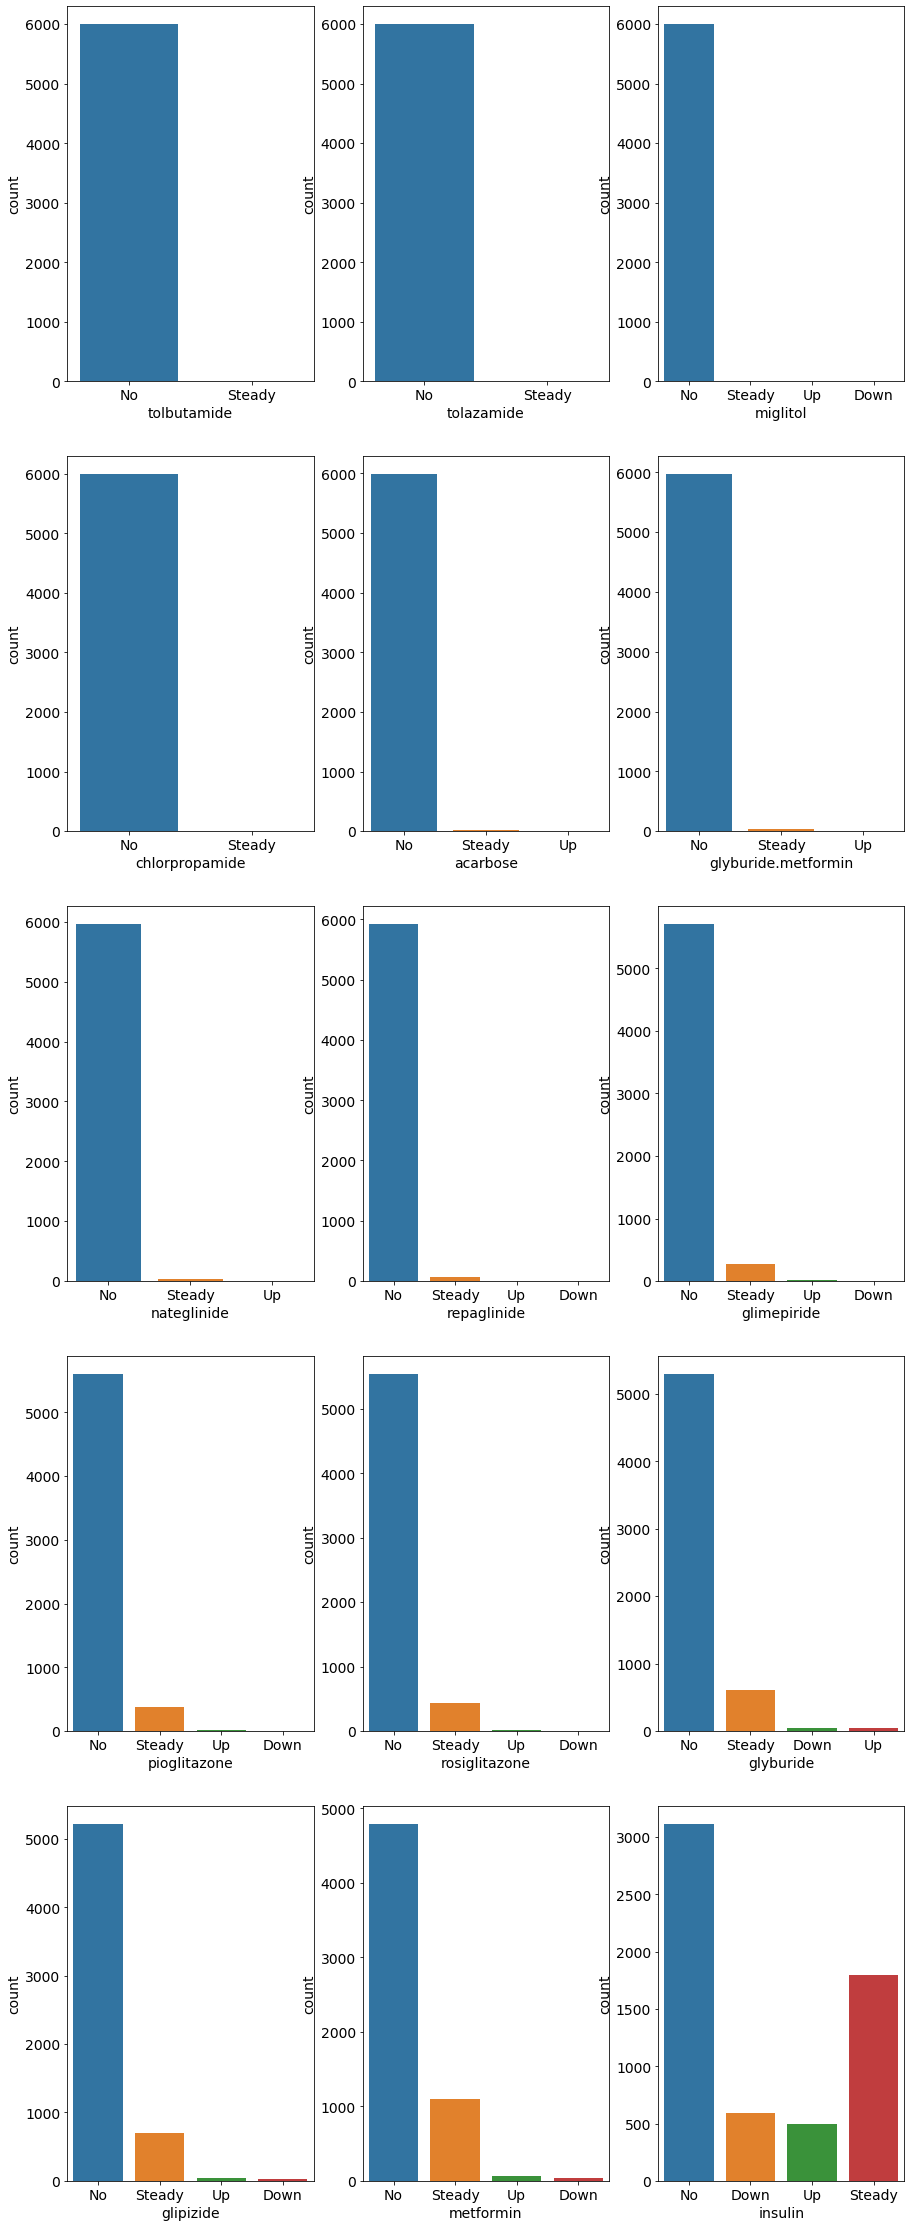

In [17]:
rows, cols = 5, 3


fig, axs = plt.subplots(rows, cols, figsize=(15,40))
for i, feat in enumerate(categorical_medicine): #enumerate(categorical_medicine_pre):
    row = i//cols
    col = i%cols
    sns.countplot(x=feat, data=X_train, ax=axs[row,col])
plt.show()

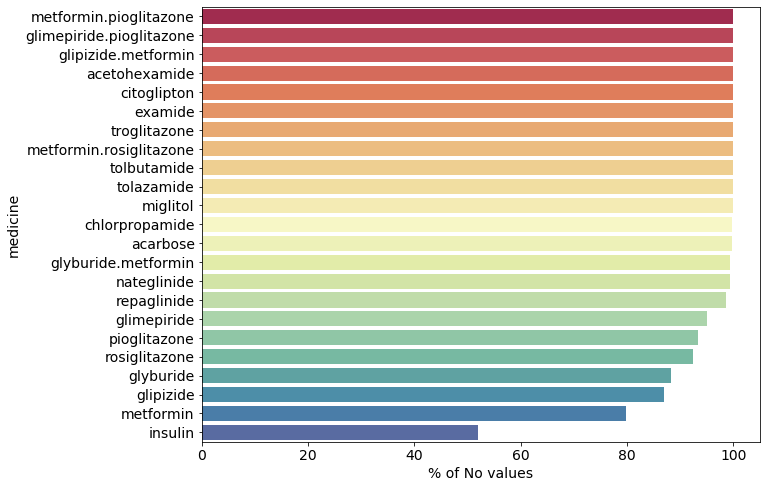

In [18]:
plt.figure(figsize=(10,8))
sns.barplot(x="% of No values",y="medicine", data=nopercent, palette="Spectral")
plt.show()

Drugs ordered by the prescription frequency. At the top are the drugs that were prescribed the least or not prescribed at all

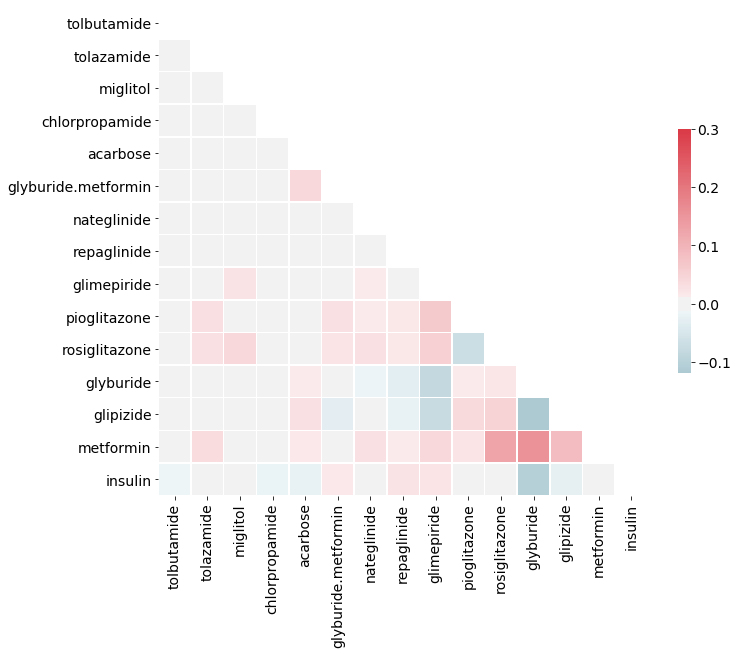

In [19]:
treat_binary = X_train[categorical_medicine]

# Can encode variables 'stea'
treat_binary = treat_binary.replace('Steady', 1)
treat_binary = treat_binary.replace('Up', 1)
treat_binary = treat_binary.replace('Down', 1)
treat_binary = treat_binary.replace('No', 0)


corr = treat_binary.corr(method='kendall') #kendall since we are dealing with categorical variables
mask = np.triu(np.ones_like(corr, dtype=np.bool))
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

Correlation matrix between meciation prescirptions

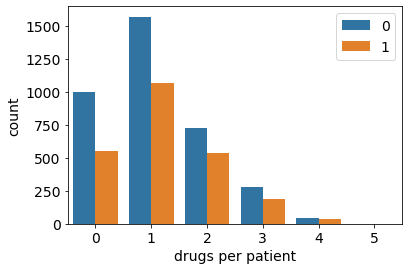

In [20]:
drugs_per_patient = treat_binary.sum(axis=1)
drugs_per_patient = pd.DataFrame(drugs_per_patient, columns=["drugs per patient"])
drugs_per_patient["readmitted"] = Y_train

drugs_plot = sns.countplot(x="drugs per patient", 
                           data=drugs_per_patient, 
                           hue = "readmitted")
drugs_plot.legend(loc=1)
plt.show()

Number of drugs prescribed per patient

In [21]:
#sum(drugs_per_patient["drugs per patient"] == 0)/ len(drugs_per_patient)
print("------------------------------------------------------------\n")
print("No. of Drugs\tPercentage\tReadmission Percentage\n")
print("------------------------------------------------------------\n")
for i in range(max(drugs_per_patient["drugs per patient"])):
    perc = sum(drugs_per_patient["drugs per patient"] == i)/ len(drugs_per_patient)
    perc2 = sum(drugs_per_patient.loc[drugs_per_patient["drugs per patient"] == i, "readmitted"] == True) / sum(drugs_per_patient["drugs per patient"] == i)
    info = "{} \t\t {:.4f}\t\t{:.4f}".format(i, perc, perc2)
    print(info)
print("------------------------------------------------------------\n")

------------------------------------------------------------

No. of Drugs	Percentage	Readmission Percentage

------------------------------------------------------------

0 		 0.2593		0.3567
1 		 0.4390		0.4043
2 		 0.2100		0.4230
3 		 0.0778		0.4026
4 		 0.0137		0.4634
------------------------------------------------------------



**Observations:**  

* for all drugs "No" is the most frequent value. 
    * only **4** drugs are prescribed to at least **10%** of subjects in the training set
    * only **15** of **23** drugs were prescribed to data subjects
* from the correlation plot below we can observe, that with the exeption of *metfomin* and *glymbirid* the drug prescriptions appear to be independent  of one another.  
* all subjects in the training set were prescribed up to **4** drugs.
    * among the people with 4 prescribed drugs, the percentage of readmitted patients was the highest. this could be also attributed however to the fact that this subsamble is very small
    * readmission percentage is the lowest among the people with only **1** drug prescribed. 

## **Numerical**

* `time_in_hospital`: integer number of days between admission and discharge
* `num_procedures`: Number of procedures (other than lab tests) performed during the encounter
* `num_lab_procedures`: Number of lab tests performed during the encounter
* `number_outpatient`: Number of outpatient visits of the patient in the year preceding the encounter
* `number_emergency`: Number of emergency visits of the patient in the year preceding the encounter
* `number_inpatient`: Number of inpatient visits of the patient in the year preceding the encounter
* `number_diagnoses`: number of diagnoses entered to the system,

In [22]:
numerical = ["time_in_hospital", "num_procedures", "num_lab_procedures",
             "number_outpatient", "number_emergency", 
             "number_inpatient", "number_diagnoses","num_medications"]

In [23]:
X_train[numerical].describe()

,time_in_hospital,num_procedures,num_lab_procedures,number_outpatient,number_emergency,number_inpatient,number_diagnoses,num_medications
count,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000
mean,4.454167,1.405167,43.013500,0.275833,0.120333,0.394167,7.050000,15.529333
std,3.033936,1.719157,19.518482,1.087020,0.722454,0.866174,2.004537,8.329468
min,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000
25%,2.000000,0.000000,32.000000,0.000000,0.000000,0.000000,5.000000,10.000000
50%,4.000000,1.000000,44.000000,0.000000,0.000000,0.000000,8.000000,14.000000
75%,6.000000,2.000000,57.000000,0.000000,0.000000,0.250000,9.000000,19.000000
max,14.000000,6.000000,120.000000,27.000000,42.000000,10.000000,9.000000,74.000000


Overview of the numerical variables

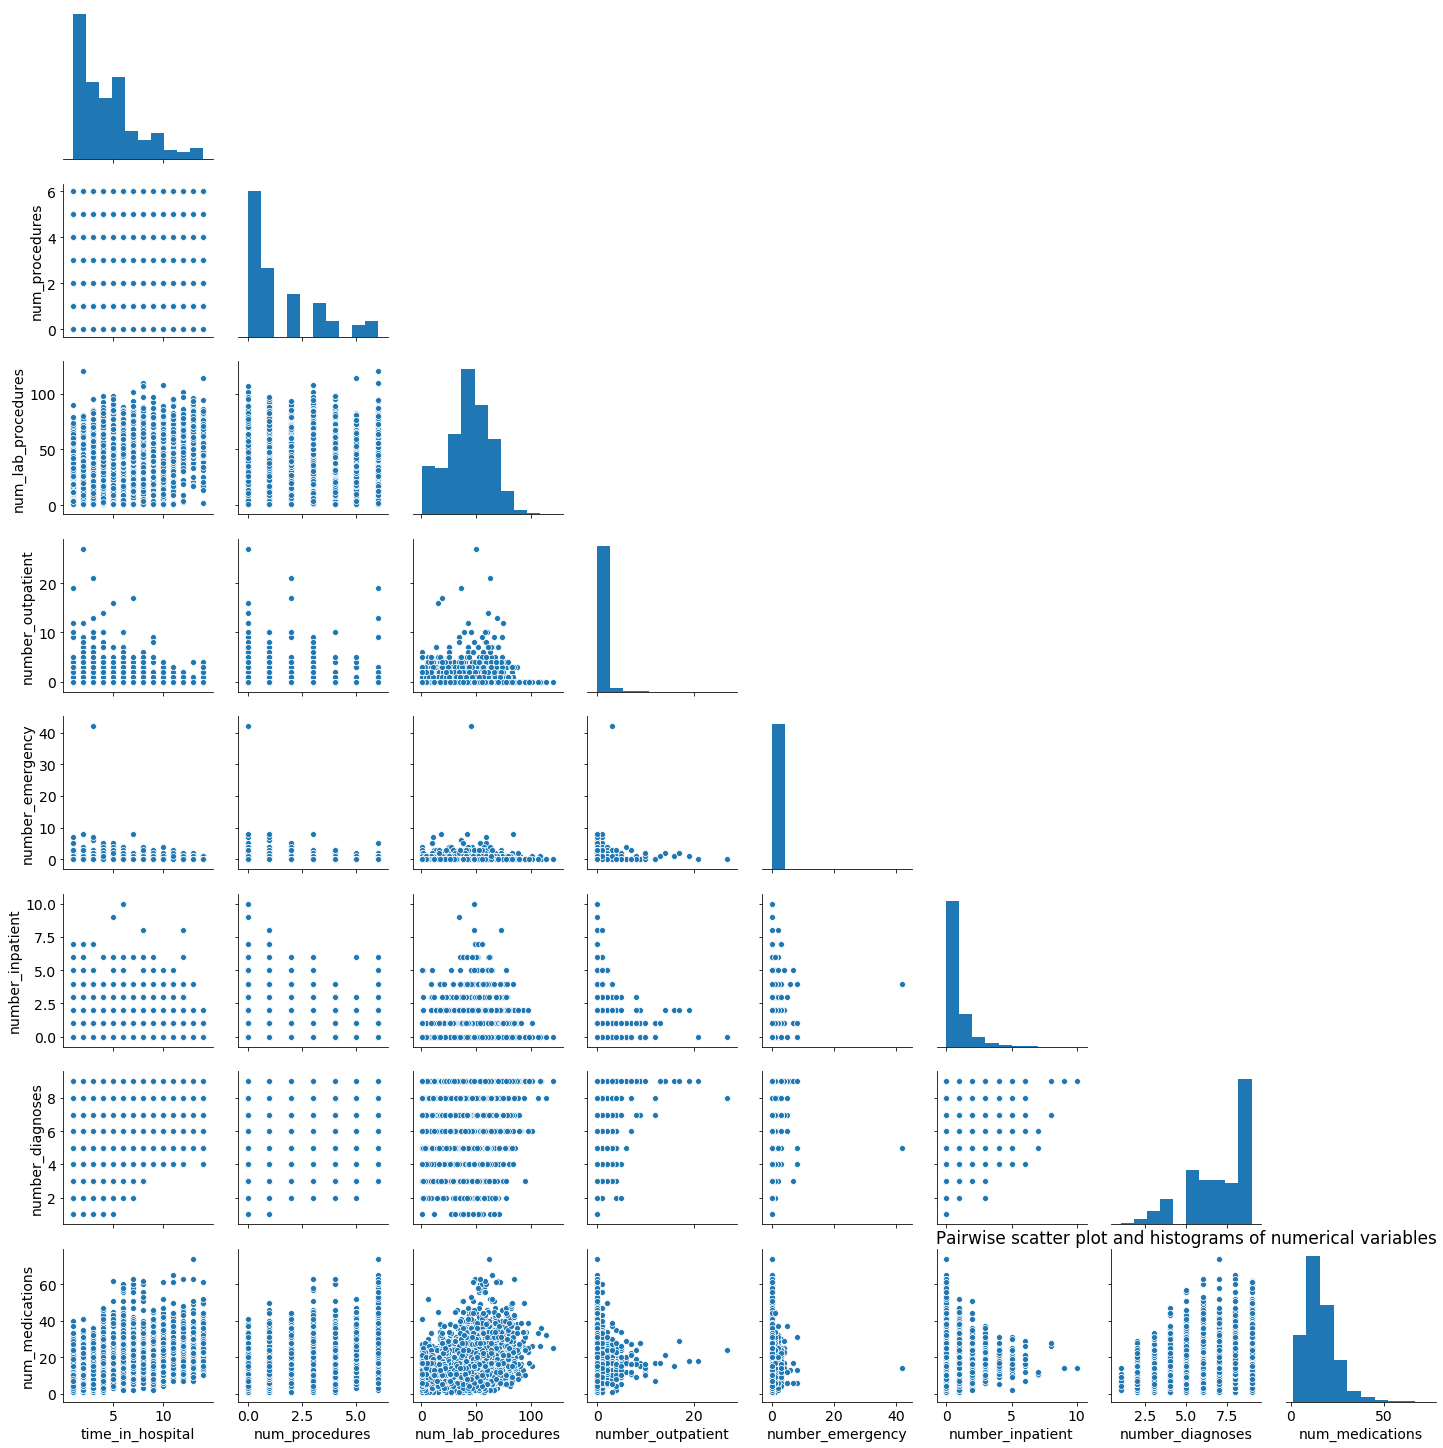

In [24]:
pl = sns.pairplot(X_Y_train[numerical], corner=True)
plt.title("Pairwise scatter plot and histograms of numerical variables")
plt.show()

Histogram and pairwise scatterplot of all numeric variables  in the dataset. Helpful for examining pariwise distributions of predictors to spot potential inter-dependencies or interesting/outlier cases 

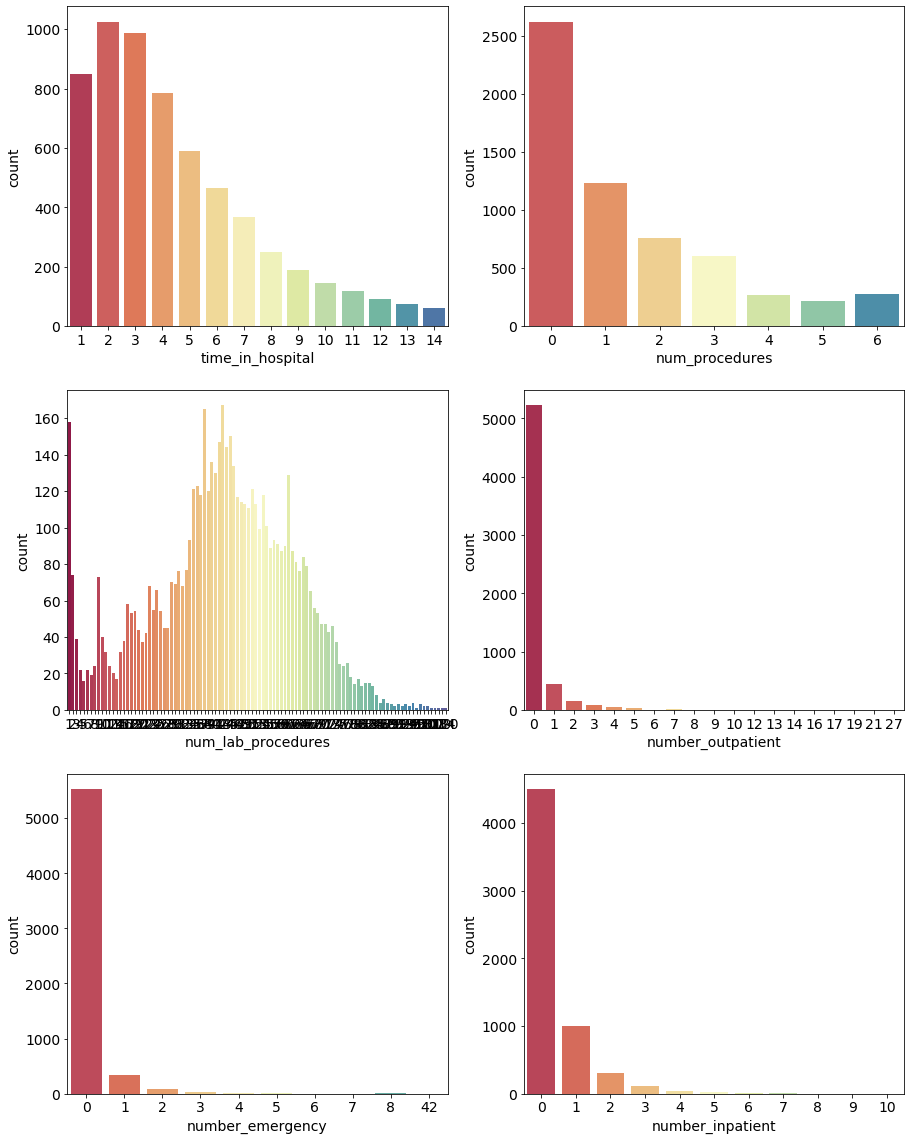

In [25]:
rows, cols = (3, 2)


fig, axs = plt.subplots(rows, cols, figsize=(15,20))
for i, feat in enumerate(numerical[:-2]):
    row = i//cols
    col = i%cols
    sns.countplot(x=feat, data=X_train, ax=axs[row,col], palette="Spectral")

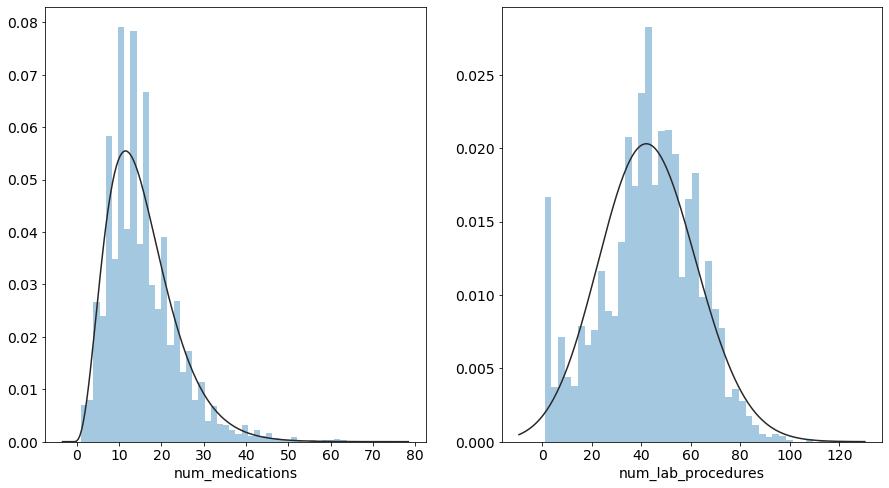

In [26]:
rows, cols = 1, 2
fig, axs = plt.subplots(rows, cols, figsize=(15,8))


for i, feat in enumerate(["num_medications", "num_lab_procedures"]): # numerical[:-2]
    row = i//cols
    col = i%cols
    sns.distplot(X_train[feat], kde=False, fit=stats.gamma, ax=axs[col])


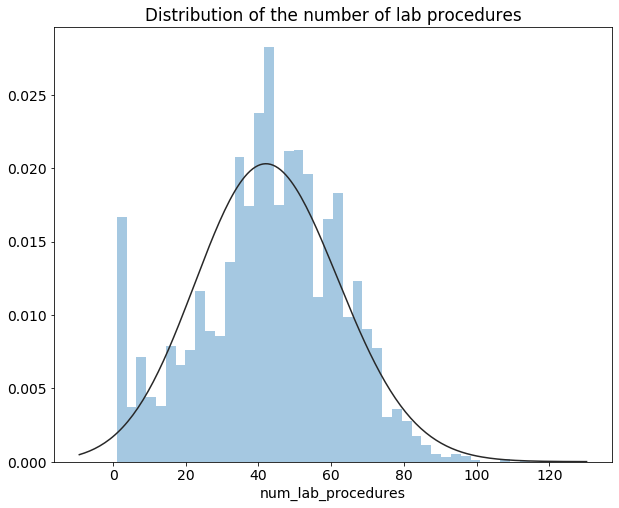

In [27]:
from scipy import stats
fig = plt.figure(figsize=(10,8))
plt.title("Distribution of the number of lab procedures")
g = sns.distplot(X_train["num_lab_procedures"], kde=False, fit=stats.gamma)
plt.show()

**Observations:**  

* `num_procedures`: number of lab tests performed during the encounter, min 0 max 6, 0 in over 40%  
* `number_diagnoses`: min 1 max 9, majority 9  
* `num_medications`: number of distinct medicine administered during the encounter, min 1 to max 74, Gaussian like shape with long tail 
* `num_lab_procedures`: from 1 to 20, Gaussian like inflated with small values
* `number_outpatient`: in over 90% 0, there are **10** patients with more than 10 `number_outpatient` and *2* with more than 20
* `number_emergency`: mostly 0,  there is 1 patient with **42** emergency visits, next greatest value is just **8**
* `number_inpatient`: values grater than in number_emergency and number_outpatient features


# **Textual variables**
## **Diagnosis code**

The dataset consists of descriptions of primary, secondary and additional secondary diagnosis. Moreover, each diagnosis was classified according to the [ICD-9 code scheme](https://en.wikipedia.org/wiki/List_of_ICD-9_codes).

First we take a look at the **ICD-9** codes of the diagnosis

In [28]:
diagnosis_codes = ["diag_1", "diag_2", "diag_3"]
diagnosis_descriptions = ["diag_1_desc", "diag_2_desc", "diag_3_desc"]

In [29]:
diag_unique = pd.DataFrame({diag: [X_train[diag].nunique()] for diag in diagnosis_codes} )

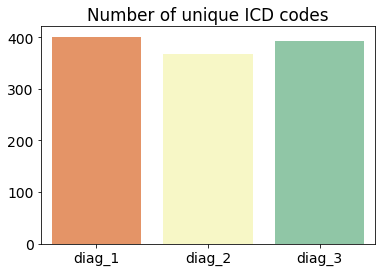

In [30]:
sns.barplot(data=diag_unique, palette="Spectral")
plt.title("Number of unique ICD codes")
plt.show()

The number of distinct diagnoses is significant - about 400. We can group the diagnoses according to the disease type (see [ICD-9 code scheme](https://en.wikipedia.org/wiki/List_of_ICD-9_codes)).

In [31]:
def map_ICD9_to_class (x):
    if(x.startswith("E")):
        return 0
    if(x.startswith("V")):
        return 1
    breakpoints = [0, 140, 240, 280, 290, 320, 390, 460, 520, 580, 630, 680, 710, 740, 760, 780, 800]
    breakpoints.reverse()
    class_nr = len(breakpoints) + 1
    for bp in breakpoints:
        if x.split(".")[0] == "?":
            return "?"
        if int(x.split(".")[0]) >= bp:
            return class_nr
        class_nr = class_nr - 1

In [32]:
diag_in_classes = X_train[diagnosis_codes].applymap(map_ICD9_to_class)

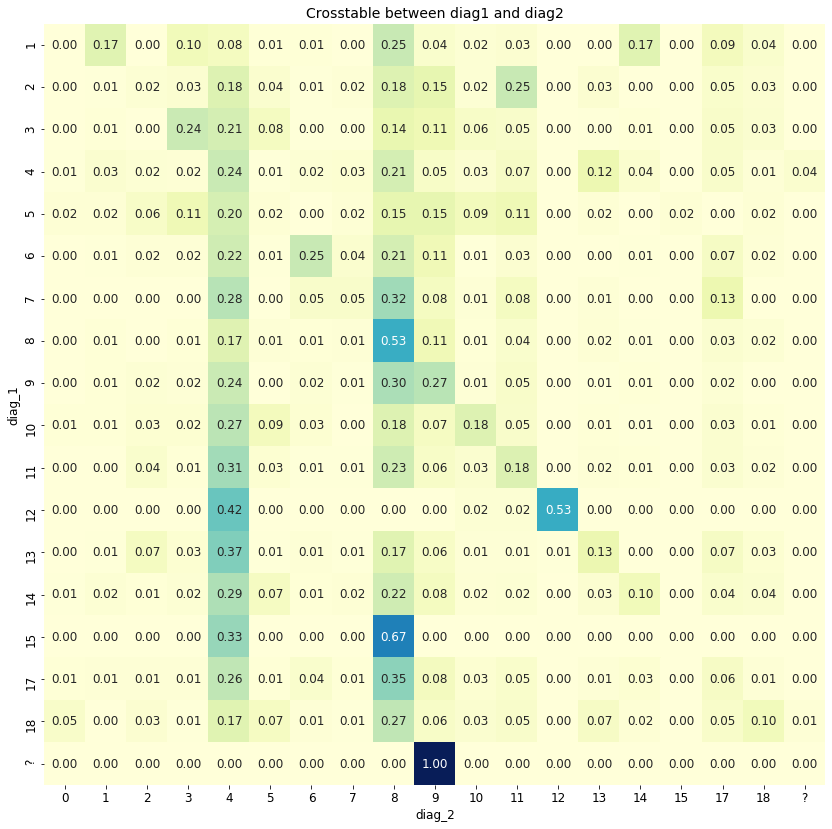

In [33]:
matplotlib.rcParams.update({'font.size': 12})
fig = plt.figure(figsize = (14, 14))

plt.title("Crosstable between diag1 and diag2", size=14)
sns.heatmap(pd.crosstab(diag_in_classes["diag_1"], diag_in_classes["diag_2"],
                       normalize='index'),
            cmap="YlGnBu", annot=True, cbar=False, fmt='.2f')
plt.show()

Crosstable to examine whether there are any systematic dependencies between ICD9 classifications for `diag_1` and `diag_2`. Values are normalized wrt the number of times each medication was prescribe

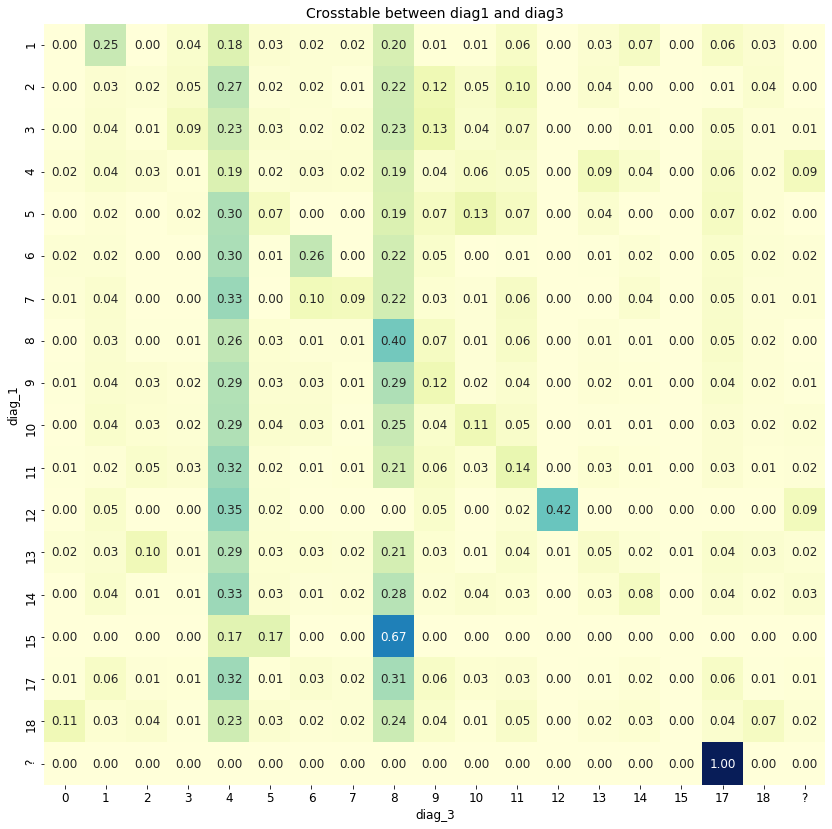

In [34]:
matplotlib.rcParams.update({'font.size': 12})
fig = plt.figure(figsize = (14, 14))

plt.title("Crosstable between diag1 and diag3", size=14)
sns.heatmap(pd.crosstab(diag_in_classes["diag_1"], diag_in_classes["diag_3"],
                        normalize='index'),
            cmap="YlGnBu", annot=True, cbar=False, fmt= '.2f' ) #fmt='g')
plt.show()

Crosstable to examine whether there are any systematic dependencies between ICD9 classifications for `diag_1` and `diag_3`

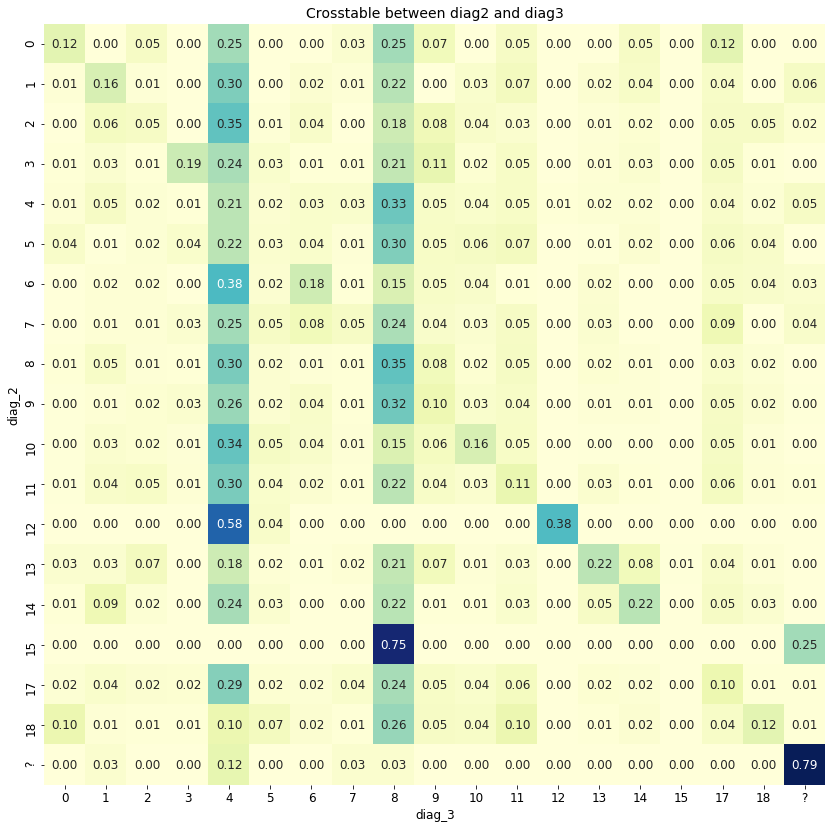

In [35]:
matplotlib.rcParams.update({'font.size': 12})
fig = plt.figure(figsize = (14, 14))

plt.title("Crosstable between diag2 and diag3", size=14)
sns.heatmap(pd.crosstab(diag_in_classes["diag_2"], diag_in_classes["diag_3"], 
                        normalize='index'),
            cmap="YlGnBu", annot=True, cbar=False, fmt= '.2f')#'g')
plt.show()

Crosstable to examine whether there are any systematic dependencies between ICD9 classifications for `diag_2` and `diag_3`. 

In [36]:
diag_in_classes_count = diag_in_classes.apply(lambda x: x.value_counts(dropna=False)).fillna(0)

In [37]:
diag_in_classes_count_unfold = diag_in_classes_count.reset_index().melt(id_vars=["index"]).\
rename(columns={"index":"diagnosis class", "variable":"diag_nr", "value":"count"})

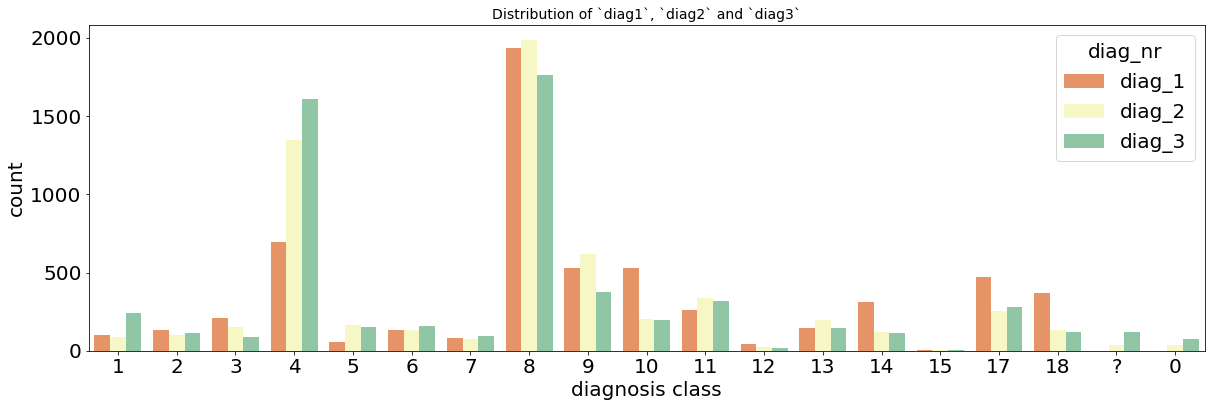

In [38]:
matplotlib.rcParams.update({'font.size': 20})

plt.figure(figsize=(20,6))
plt.title("Distribution of `diag1`, `diag2` and `diag3`", size=14)
sns.barplot(x="diagnosis class", y= "count", hue= "diag_nr", data=diag_in_classes_count_unfold, palette="Spectral")
plt.show()

Distribution of `diag1`, `diag2` and `diag3` in the *training dataset*

In [39]:
diagnosis_length = X_train[diagnosis_descriptions].transform(lambda x: x.str.len())

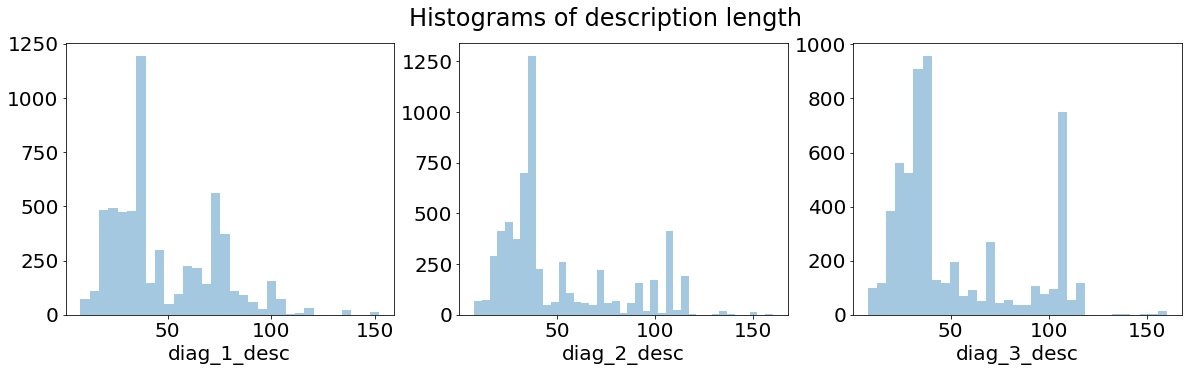

In [40]:
rows, cols = 1, 3

fig, axs = plt.subplots(rows, cols, figsize=(20,5))
fig.suptitle("Histograms of description length")
for i, feat in enumerate(diagnosis_descriptions):
    row = i//cols
    col = i%cols
    sns.distplot(diagnosis_length[feat], ax=axs[col], kde=False)
plt.show()

Disribution of the number of words per diagnosis

**Observations**

* there are a lot of patients with class 8 (390–459 - *diseases of the circulatory system* ), second popular diagnosis is 4 (240 - 279 *Endocrine, Nutritional and Metabolic Diseases, and Immunity Disorders*)
* in the crosstable we can notice some associations between the ICD9 codes for the primary and secondary diagnoses. for instance: 8 & 15, 4 & 12, 12 & 12 are often diagnosed simultaneously
    

## **Diagnosis description**
### Features transformations

In [41]:
# select features
class Selector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names]

# drop features
class Dropper(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X.drop(columns = self.attribute_names)

# impute missing values
class MissingChanger(BaseEstimator, TransformerMixin):
    def __init__(self, features, constant):
        self.features = features
        self.constant = constant
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.features].fillna(self.constant)

# apply function to some features
class FeatureModifier(BaseEstimator, TransformerMixin):
    def __init__(self, features, func):
        self.features = features
        self.func = func
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        Xnew = X.copy()
        Xnew[self.features] = Xnew[self.features].applymap(lambda x: self.func(x))
        return Xnew

### Text transformations


In [42]:
# textual transformations

class Tokenizer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X.applymap(lambda x: word_tokenize(x))

class Stemmer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.stemmer = PorterStemmer()
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X.applymap(lambda x: [self.stemmer.stem(word) for word in x])


class StopWordsFilter(BaseEstimator, TransformerMixin):
    def __init__(self, extra_words=[]):
        self.stopwords = stopwords.words('english') + list(string.punctuation) + extra_words
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X.applymap(lambda x: [word for word in x if word not in self.stopwords])

class LowerCaseTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X.applymap(lambda x: [word.lower() for word in x])

class TfidFromSentencesTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.vectorizer = TfidfVectorizer()
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X.applymap(lambda x: self.vectorizer.fit_tr)

In [43]:
textual_preprocessing_pipeline = Pipeline([
        ("select_textual_features", Selector(diagnosis_descriptions)),
        ("add_missing_class", MissingChanger(diagnosis_descriptions, "")),
        ("tokenize", Tokenizer()),
        ("filter_stop_words", StopWordsFilter()),
        ("perform_stemming", Stemmer()),
    ])

In [44]:
# transform arrays of words back in the sentenses
back_to_sentece_pipeline = Pipeline([("text_preprocessing", textual_preprocessing_pipeline),
                                      ("join_words", FeatureModifier(diagnosis_descriptions, \
                                                                     lambda x: " ".join(x)))])

In [45]:
# find word_to_vec model
def get_word_to_vec_model(X, pipeline = textual_preprocessing_pipeline):
    transformed_text = pipeline.fit_transform(X)
    transformed_text = np.concatenate([transformed_text[feature].values for feature in diagnosis_descriptions])
    transformed_labels = np.concatenate([Y_train.values for feature in diagnosis_descriptions])
    model = Word2Vec(transformed_text, size=30, min_count=5)
    vocab = list(model.wv.vocab)
    return model, transformed_text, transformed_labels

In [46]:
# find tfid transformation for each document
def get_tfid (X, Y, vectorizer=None, pipeline = back_to_sentece_pipeline):
    transformed_text = pipeline.fit_transform(X)
    transformed_text = np.concatenate([transformed_text[feature].values for feature in diagnosis_descriptions])
    transformed_index = np.concatenate([Y.index for feature in diagnosis_descriptions])
    transformed_labels = np.concatenate([Y.values for feature in diagnosis_descriptions])
    if vectorizer is None:
        vectorizer = TfidfVectorizer()
        vectorizer.fit(transformed_text)
    tfid_text = vectorizer.transform(transformed_text)
    return {"text":tfid_text, "index": transformed_index, "labels":transformed_labels, "vectorizer":vectorizer}


In [47]:
tfid_text = get_tfid(X_train, Y_train)

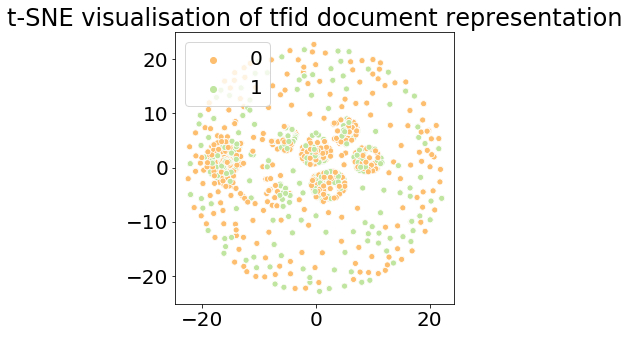

In [48]:
plt.figure(figsize=(5, 5))
X_embedded = TSNE(n_components=2, perplexity=5, learning_rate=5, random_state=1337)\
                .fit_transform(tfid_text["text"])

sns.scatterplot(x=X_embedded[:, 0], y=X_embedded[:,1], hue=tfid_text["labels"], legend = "full", palette="Spectral")
plt.title("t-SNE visualisation of tfid document representation")
plt.show()

In [49]:
vec_model, vec_text, vec_labels = get_word_to_vec_model(X_train)
vec_vocab = list(vec_model.wv.vocab)

In [50]:
vec_counts = {word: [0,0] for word in vec_vocab}
for doc_id, doc in enumerate(vec_text):
    for word in doc:
        if word in vec_vocab:
            class_nr = vec_labels[doc_id]
            counts = vec_counts[word]
            counts[class_nr] = counts[class_nr] + 1
            vec_counts[word] = counts

In [51]:
vec_counts_total = [ float(vec_counts[word][0])/sum(vec_counts[word]) for word in vec_vocab]

In [52]:
vec_vectors = [vec_model.wv[word] for word in vec_vocab]

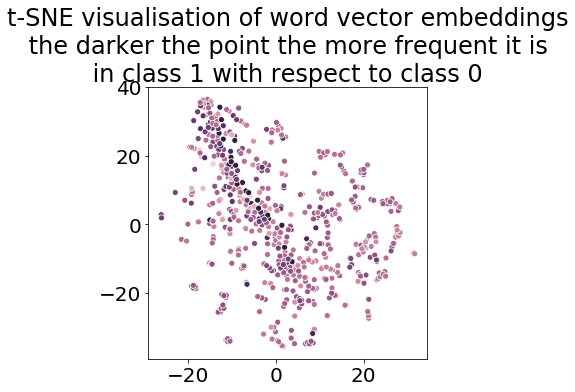

In [53]:
plt.figure(figsize=(5, 5))
X_embedded = TSNE(n_components=2, random_state=1337).fit_transform(vec_vectors)

sns.scatterplot(x=X_embedded[:, 0], y=X_embedded[:,1],legend=False, hue=vec_counts_total)
plt.title("t-SNE visualisation of word vector embeddings\n the darker \
the point the more frequent it is \n in class 1 with respect to class 0 ")
plt.show()

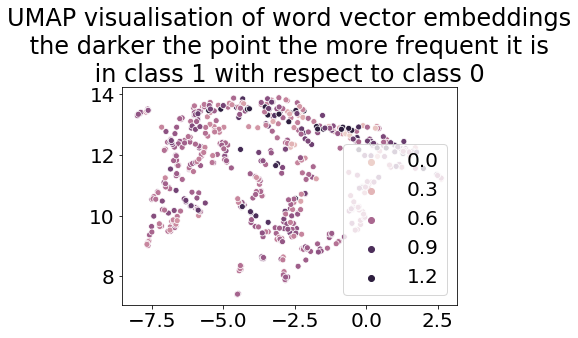

In [54]:
standard_embedding = umap.UMAP(random_state=42).fit_transform(X=vec_vectors)

sns.scatterplot(standard_embedding[:,0], standard_embedding[:, 1], hue=vec_counts_total)
plt.title("UMAP visualisation of word vector embeddings\n the darker \
the point the more frequent it is \n in class 1 with respect to class 0 ")
plt.show()

The above plots suggest that very simple approaches such as tfid vectors representing documents or single words embeddings might not be good enough inidicators of the class.

In [55]:
wordcloud_pipeline = Pipeline([
        ("select_textual_features", Selector(diagnosis_descriptions)),
        ("add_missing_class", MissingChanger(diagnosis_descriptions, "")),
        ("tokenize", Tokenizer()),
        ("filter_stop_words", StopWordsFilter(["unspecified", "without"])),
        ("to_lower_case", LowerCaseTransformer()),
    ])

In [56]:
def generate_world_cloud(class_nr):
    to_cloud = wordcloud_pipeline.fit_transform(X_train.where(Y_train==class_nr))
    all_tokens = []
    for ind in range(0, to_cloud.shape[0]):
        for text in to_cloud.iloc[ind]:
            for word in text:
                all_tokens.append(word)
    frequency_dist = FreqDist(all_tokens)
    wordcloud = WordCloud().generate_from_frequencies(frequency_dist)
    return wordcloud

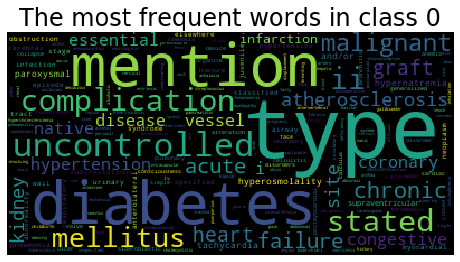

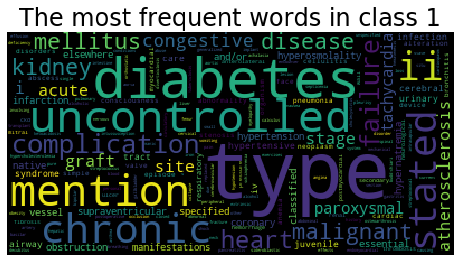

In [57]:
for class_nr in [0,1]:
    plt.figure(figsize=(8,8))
    wordcloud = generate_world_cloud(class_nr)
    plt.imshow(wordcloud)
    plt.title("The most frequent words in class {}".format(class_nr))
    plt.axis("off")
    plt.show()

The most frequent words are similar in both classes. As expected many are diabetes related such as "diabetes", "ty[e", "complication", "chronic".

In [58]:
not_stemming_pipeline = Pipeline([
        ("select_textual_features", Selector(diagnosis_descriptions)),
        ("add_missing_class", MissingChanger(diagnosis_descriptions, "")),
        ("tokenize", Tokenizer()),
        ("filter_stop_words", StopWordsFilter()),
        ("to_lower_case", LowerCaseTransformer()),
    ])

codes_preprocessing_pipeline = Pipeline([
        ("select_textual_features", Selector(diagnosis_codes)),
        ("add_missing_class", FeatureModifier(diagnosis_codes, map_ICD9_to_class)),
    ])

### **Latent dirichlet allocation for topic modelling**

In [59]:
def perform_lda(pipeline= not_stemming_pipeline, num_topics=10):
    transformed_text = pipeline.fit_transform(X_train)
    transformed_text = np.concatenate([transformed_text[feature].values for feature in diagnosis_descriptions])
    transformed_labels = np.concatenate([Y_train.values for feature in diagnosis_descriptions])
    dictionary_LDA = corpora.Dictionary(transformed_text)
    corpus = [dictionary_LDA.doc2bow(document) for document in transformed_text]
    lda_model = models.LdaModel(corpus, num_topics=num_topics, \
                            id2word=dictionary_LDA, \
                            passes=4, alpha=[0.01]*num_topics, \
                            eta=[0.01]*len(dictionary_LDA.keys()))
  
    return lda_model, corpus, dictionary_LDA

In [60]:
lda_model, corpus, dictionary_LDA = perform_lda()

In [61]:
vis = pyLDAvis.gensim.prepare(topic_model=lda_model, corpus=corpus, dictionary=dictionary_LDA)
pyLDAvis.enable_notebook()
pyLDAvis.display(vis)

In [62]:
def ICD9_map_back(x):
    if x == "?":
        return "?"
    if x == 0:
        return "E codes"
    if x == 1:
        return "V codes"
    x = int(x - 2)
    bps = [0, 140, 240, 280, 290, 320, 390, 460, 520, 580, 630, 680, 710, 740, 760, 780, 800, 999]
    return "{}-{} codes".format(bps[x], bps[x+1])

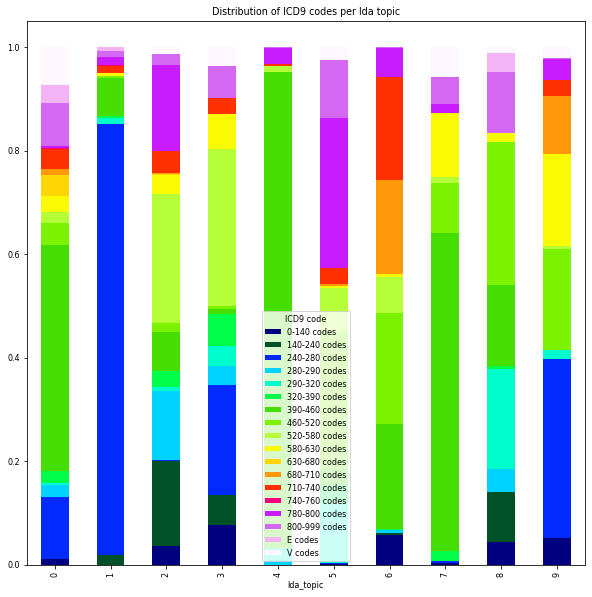

In [63]:
matplotlib.rcParams.update({'font.size': 8})
topic_assignments = [lda_model[doc][0][0] for doc in corpus]
codes_as_classes = codes_preprocessing_pipeline.fit_transform(X_train)
codes_as_classes = np.concatenate([codes_as_classes[feature].values for feature in diagnosis_codes])
codes_as_classes = np.array([ICD9_map_back(x) for x in codes_as_classes])
lda_codes = pd.DataFrame({"ICD9 code":codes_as_classes, "lda_topic":topic_assignments})
lda_codes = lda_codes[lda_codes["ICD9 code"] != "?"]
props = lda_codes.groupby("lda_topic")["ICD9 code"].value_counts(normalize=True).unstack()
f, ax = plt.subplots(figsize=(10, 10))
plt.title("Distribution of ICD9 codes per lda topic")
props.plot(kind='bar', stacked='True', ax=ax, cmap="gist_ncar")
plt.show()

LDA finds some topics that are specifically related to some particular diseases, such as heart or kidney conditions. The plot above can be used to explore how the found topics relate to the ICD9 codes and if maybe the can observe broader topics than ICD9.

## **Final observations:**  
The above exploratory analysis suggests that simple approaches do not offer any direct information. ICD9 codes provide very specific analysis of what type of disease the diagnosis refers to - almost 400 unique ICD codes per each diagnosis type. The length of most diagnosis is less than 40 words so there is limited information than can be gained different to what ICD9 codes already provide.

# **Missing Values**

We would like to take a look at the structure of missingness in the data. Our objective is to do a preliminary check, whether we can observe a pattern. 

Three situations might take place:

1. Missing completely at random (MCAR)
2. Missing at random (MAR)
3. Missing not at random (MNAR)

In case **1)** and **2)** it is reasonable to try to impute missing values, whereas in case **3)** and procedure might lead to biases, therefore at least for categorical variables, it would be reasonable to eoncode this state separately or entirely exclude them from the analysis.


The code at the beginning of the notebook allow us to examine unique values of different variables. Based on this we have concluded that the following entries (alongsize with standard np.nan) encodes the fact that the variable is missing.

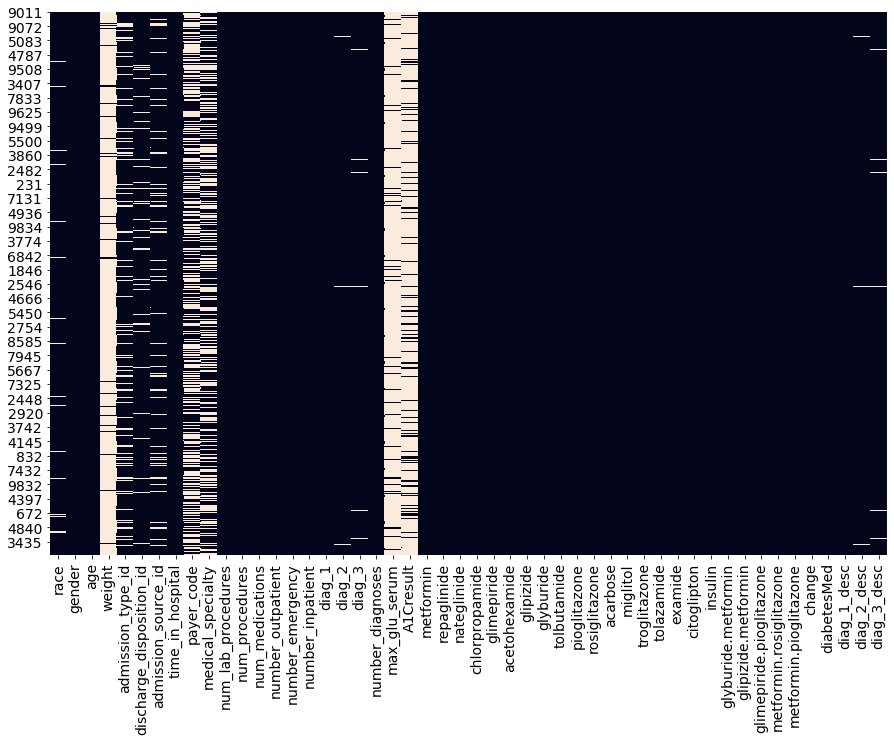

In [64]:
missing_symbols = ['?', 'None','Not Available', 'Not Mapped']

for val in missing_symbols:
    X_train = X_train.replace(val, np.nan)

matplotlib.rcParams.update({'font.size': 14})
fig = plt.figure(figsize = (15, 10))
sns.heatmap(X_train.isnull(), cbar=False)
plt.show()

In [65]:
missing_threshold = 0.4  # separately examine these variables

missing_value = X_train.apply(lambda x: sum(x.isnull())/len(X_train) ).sort_values(ascending=False)
mostly_missing = list(missing_value[missing_value > missing_threshold].index)
missing_value[missing_value > 0]

weight                      0.959500
max_glu_serum               0.936000
A1Cresult                   0.836833
payer_code                  0.535167
medical_specialty           0.406667
admission_type_id           0.130667
admission_source_id         0.094167
discharge_disposition_id    0.059500
race                        0.020667
diag_3                      0.020333
diag_3_desc                 0.020333
diag_2                      0.005667
diag_2_desc                 0.005667
diag_1                      0.000167
diag_1_desc                 0.000167
dtype: float64

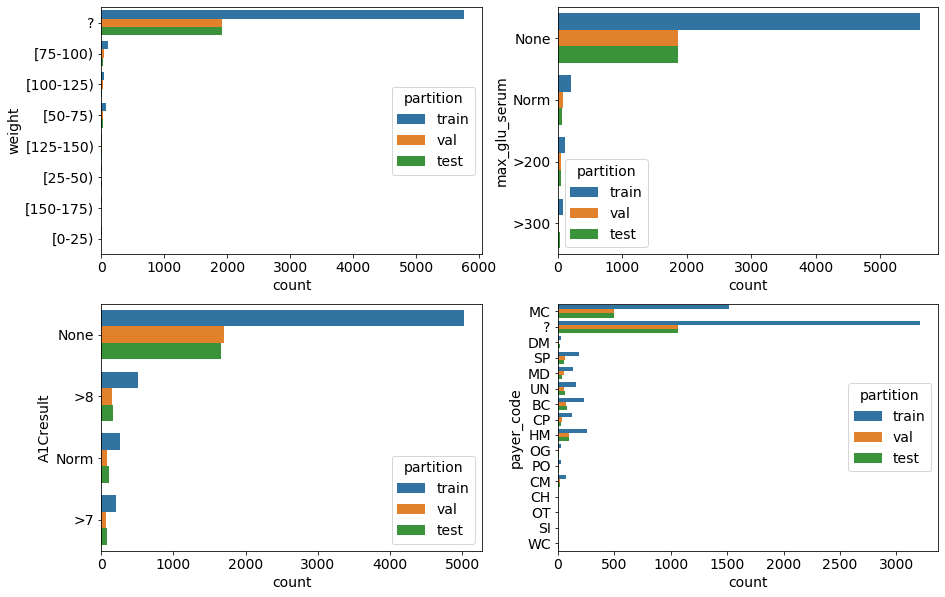

In [66]:
mostly_missing = ['weight', 'max_glu_serum', 'A1Cresult', 'payer_code']
matplotlib.rcParams.update({'font.size': 14})
rows, cols = 2, 2

fig, axs = plt.subplots(rows, cols, figsize=(15,10))

for i, feat in enumerate(mostly_missing):
    row = i//cols
    col = i%cols
    sns.countplot(y=feat, data=X_Y_all, ax=axs[row,col], hue = "partition") 
    
plt.show()

In [67]:
X_train['medical_specialty'].value_counts().head(5)

InternalMedicine          1134
Family/GeneralPractice     544
Cardiology                 423
Emergency/Trauma           316
Surgery-General            209
Name: medical_specialty, dtype: int64

**Observations:**  
* `weight`: over 95% of missing values   
* `max_glu_serum`: over 93% of missing values   
* `A1Cresult`: over 83% of missing values
* `payer_code`: payment method such as Blue Cross, Medicare, and self-pay, over 50% missing values
* `diag_i_desc` and `diag_i` are missing simultaneusly